# For code testing and analysis

### !!! Disclaimer !!! ###
My version of pyPMF is not the same as the github version, as I have altered my version to account for deprecation of the github version. I will try to update my library so it can be used by all


### Analysis
4 factors are to few to include in the analysis for the 2011-2023 interval \
For the 5 factor analysis a downgrading of species with S/N < 0.5 is tried

In [1]:
import pyPMF
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import YearLocator, DateFormatter
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
warnings.filterwarnings('ignore', category=FutureWarning, module='pyPMF')

In [80]:
def custom_date_formatter(x, pos):
    dt = mdates.num2date(x)
    if dt.month == 1:  # Show year in January
        return dt.strftime('%b %Y')
    return dt.strftime('%b')  # Show only month for others


def plot_yearly_variation_mean(df: pd.DataFrame, factor: str) -> None:
    plot_df = df.copy()
    plot_df.reset_index(inplace=True)
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])  # Ensure 'Date' is datetime
    plot_df.set_index('Date', inplace=True)

    # Extract years and create storage for yearly df
    years = sorted(plot_df.index.year.unique())
    yearly_values = []

    # Create figure
    plt.figure(figsize=(20, 12))

    # Get maximum length for padding
    max_weeks = 53

    # Plot each year in grayscale (lighter for older years, darker for recent years)
    for i, (year, group) in enumerate(plot_df.groupby(plot_df.index.year)):
        normalized_shade = 0.3 + 0.6 * (i / (len(years) - 1))  # Scale gray from light (oldest) to dark (newest)

        # Get week numbers and ensure correct shape
        week_numbers = group.index.isocalendar().week
        soil_values = group[factor].values

        # Create an array of NaNs and fill in the values
        padded_values = np.full(max_weeks, np.nan)
        for week, value in zip(week_numbers, soil_values):
            padded_values[week - 1] = value  # Subtract 1 for zero-based index

        # Only plot the non-NaN values for the current year
        plt.plot(range(1, max_weeks + 1), padded_values, color=(normalized_shade,) * 3, alpha=0.4)

        yearly_values.append(padded_values)

    # Convert yearly_values to a numpy array for quantile calculations
    yearly_values = np.array(yearly_values)

    # Compute mean and quantiles
    mean_values = np.nanmean(yearly_values, axis=0)
    lower_quantile = np.nanpercentile(yearly_values, 25, axis=0)
    upper_quantile = np.nanpercentile(yearly_values, 75, axis=0)

    # Plot the mean as a bold black line
    plt.plot(range(1, max_weeks + 1), mean_values, color='black', linewidth=2, label='Mean')

    # Fill area between 25th and 75th percentiles
    plt.fill_between(range(1, max_weeks + 1), lower_quantile, upper_quantile, color='black', alpha=0.2)

    plt.ylabel('PM [ng/m$^3$]', fontsize=18)
    plt.title(f'Yearly Variation of {factor} Source', fontsize=24)
    plt.legend(loc='upper right', fontsize=16, frameon=False)
    plt.xticks([1, 13, 26, 39, 48], ['Jan', 'Apr', 'Jul', 'Oct', 'Dec'])  # Week markers
    plt.xlim(1, max_weeks)  # Set x-axis limits
    plt.tick_params(which='both', labelsize=16, size=10)
    

def plot_yearly_variation_median(df: pd.DataFrame, factor: str) -> None:
    plot_df = df.copy()
    plot_df.reset_index(inplace=True)
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])  # Ensure 'Date' is datetime
    plot_df.set_index('Date', inplace=True)

    # Extract years and create storage for yearly df
    years = sorted(plot_df.index.year.unique())
    yearly_values = []

    # Create figure
    plt.figure(figsize=(20, 12))

    # Get maximum length for padding
    max_weeks = 53

    # Plot each year in grayscale (lighter for older years, darker for recent years)
    for i, (year, group) in enumerate(plot_df.groupby(plot_df.index.year)):
        normalized_shade = 0.3 + 0.6 * (i / (len(years) - 1))  # Scale gray from light (oldest) to dark (newest)

        # Get week numbers and ensure correct shape
        week_numbers = group.index.isocalendar().week
        soil_values = group[factor].values

        # Create an array of NaNs and fill in the values
        padded_values = np.full(max_weeks, np.nan)
        for week, value in zip(week_numbers, soil_values):
            padded_values[week - 1] = value  # Subtract 1 for zero-based index

        # Only plot the non-NaN values for the current year
        plt.plot(range(1, max_weeks + 1), padded_values, color=(normalized_shade,) * 3, alpha=0.4)

        yearly_values.append(padded_values)

    # Convert yearly_values to a numpy array for quantile calculations
    yearly_values = np.array(yearly_values)

    # Compute mean and quantiles
    mean_values = np.nanmedian(yearly_values, axis=0)
    lower_quantile = np.nanpercentile(yearly_values, 25, axis=0)
    upper_quantile = np.nanpercentile(yearly_values, 75, axis=0)

    # Plot the mean as a bold black line
    plt.plot(range(1, max_weeks + 1), mean_values, color='black', linewidth=2, label='Median')

    # Fill area between 25th and 75th percentiles
    plt.fill_between(range(1, max_weeks + 1), lower_quantile, upper_quantile, color='black', alpha=0.2)

    plt.ylabel('PM [ng/m$^3$]', fontsize=18)
    plt.title(f'Yearly Variation of {factor} Source', fontsize=24)
    plt.legend(loc='upper right', fontsize=16, frameon=False)
    plt.xticks([1, 13, 26, 39, 48], ['Jan', 'Apr', 'Jul', 'Oct', 'Dec'])  # Week markers
    plt.xlim(1, max_weeks)  # Set x-axis limits
    plt.tick_params(which='both', labelsize=16, size=10)
    
    
def plot_mean_factor_variation(df: pd.DataFrame) -> None:
    plot_df = df.copy()
    plot_df.reset_index(inplace=True)
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])  # Ensure 'Date' is datetime
    plot_df.set_index('Date', inplace=True)

    max_weeks = 53
    n_factors = len(plot_df.columns)
    factor_yearly_vals = np.empty((0, max_weeks))
    yearly_mean_factor = {}
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))

    # Get maximum length for padding
    colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']
    
    for col in plot_df.columns:
        
        yearly_values = []
        # Plot each year in grayscale (lighter for older years, darker for recent years)
        for i, (_, group) in enumerate(plot_df.groupby(plot_df.index.year)):
            
            # Get week numbers and ensure correct shape
            week_numbers = group.index.isocalendar().week
            soil_values = group[col].values

            # Create an array of NaNs and fill in the values
            padded_values = np.full(max_weeks, np.nan)
            for week, value in zip(week_numbers, soil_values):
                padded_values[week - 1] = value  # Subtract 1 for zero-based index

            yearly_values.append(padded_values)

        # Convert yearly_values to a numpy array for quantile calculations
        yearly_values = np.array(yearly_values)

        # Compute mean and quantiles
        mean_values = np.nanmedian(yearly_values, axis=0)
        yearly_mean_factor[col] = mean_values
        factor_yearly_vals = np.vstack((factor_yearly_vals, mean_values))
        
    tspm = np.sum(factor_yearly_vals, axis=0)
    d_index = [i+1 for i in range(tspm.shape[0])]
    cumulative = pd.Series(0, index=d_index)
    
    for col, color in zip(plot_df.columns, colors[:n_factors]):
        # Plot the mean as a bold black line
        ax.fill_between(
            d_index,
            cumulative + (yearly_mean_factor[col] / tspm),  # Upper boundary of the area
            cumulative,            # Lower boundary of the area
            color=color,
            alpha=0.5,
            label=col
        )
        cumulative += yearly_mean_factor[col] / tspm  # Update cumulative sum for the next layer

    ax.set_ylabel('Normalized Contribution to Aerosol Mass', fontsize=18)
    plt.title(f'Yearly Variation of Factors', fontsize=24)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.015), fontsize=16)
    plt.xticks([1, 13, 26, 39, 48], ['Jan', 'Apr', 'Jul', 'Oct', 'Dec'])  # Week markers
    ax.set_xlim(1, max_weeks)  # Set x-axis limits
    ax.set_ylim([0, 1])
    plt.tick_params(which='both', labelsize=16, size=10)
    

def factor_scatter(df: pd.DataFrame):
    col_names = df.columns
    n_factors = len(col_names)
    # Create a subplot grid
    fig, axes = plt.subplots(n_factors, n_factors, figsize=(4.6 * n_factors, 4 * n_factors), sharex=False, sharey=False)

    # Loop through each pair of columns
    for i in range(n_factors):
        for j in range(n_factors):
            ax = axes[i, j]

            if i > j:  # Lower triangle (scatter plots)
                ax.scatter(df.iloc[:, j], df.iloc[:, i], alpha=0.5)
            elif i == j:  # Diagonal (histograms)
                ax.hist(df.iloc[:, i], bins=20, color='gray', alpha=0.7, density=True)
                ax.set_ylabel('Density', fontsize=18)
                if df.iloc[:, i].equals(df.iloc[:, -1]):
                    ax.set_xlabel(f'{col_names[j]} [ng/m3]', fontsize=24)
            else:  # Upper triangle (empty)
                ax.axis("off")

            # Set x and y labels
            if j == 0 and i != 0:  # Only set y-axis label on first column
                ax.set_ylabel(f'{col_names[i]} [ng/m3]', fontsize=24)
            if i == n_factors - 1 and j != n_factors - 1:  # Only set x-axis label on bottom row
                ax.set_xlabel(f'{col_names[j]} [ng/m3]', fontsize=24)
            ax.tick_params(which='both', labelsize=18, size=12)
    # Adjust layout
    plt.tight_layout()

In [3]:
postNuukNoBr_4 = pyPMF.PMF(site='postNuukNoBr', reader='xlsx', BDIR='TSPM_runs/postNuukNoBr/weak_species/4_factor/')
postNuukNoBr_5 = pyPMF.PMF(site='postNuukNoBr', reader='xlsx', BDIR='TSPM_runs/postNuukNoBr/weak_species/5_factor/')
postNuukNoBr_6 = pyPMF.PMF(site='postNuukNoBr', reader='xlsx', BDIR='TSPM_runs/postNuukNoBr/weak_species/6_factor/')
postNuukAll_4 = pyPMF.PMF(site='postNuukAll', reader='xlsx', BDIR='TSPM_runs/postNuukAll/weak_species/4_factor/')
postNuukAll_5 = pyPMF.PMF(site='postNuukAll', reader='xlsx', BDIR='TSPM_runs/postNuukAll/weak_species/5_factor/')
postNuukAll_6 = pyPMF.PMF(site='postNuukAll', reader='xlsx', BDIR='TSPM_runs/postNuukAll/weak_species/6_factor/')

### 2011-2014

In [4]:
postNuukNoBr_4.read.read_base_profiles()
postNuukNoBr_4.read.read_base_contributions()
postNuukNoBr_4.read.read_base_uncertainties_summary()
postNuukNoBr_4.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]


In [5]:
postNuukNoBr_5.read.read_base_profiles()
postNuukNoBr_5.read.read_base_contributions()
postNuukNoBr_5.read.read_base_uncertainties_summary()
postNuukNoBr_5.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]


In [6]:
postNuukNoBr_6.read.read_base_profiles()
postNuukNoBr_6.read.read_base_contributions()
postNuukNoBr_6.read.read_base_uncertainties_summary()
postNuukNoBr_6.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]
Warging: trying to exclude non-convergente BS
BS eliminated:
                            Boot0      Boot1       Boot2       Boot3  \
Specie       Profile                                                   
Al [ng/m3]   Factor 1    0.108738    1.32009    1.241610    0.721701   
             Factor 2    0.070825    0.41127    0.578874    0.747631   
             Factor 3    0.964638    2.66251    0.119751    0.374995   
             Factor 4   15.002900   14.17120   13.270300   14.618400   
             Factor 5    0.871065    0.69788    1.005880    0.314624   
...                           ...        ...         ...         ...   
TSPM [ng/m3] Factor 2  276.720000  298.88000  298.394000  321.035000   
             Factor 3   77.434200   83.83160  102.274000   76.023000   
             Factor 4  169.197000  162.51000  203.864000  154.873000   
             Factor 5  159.846000  209.27700  152.969000  130.617000

In [ ]:
postNuukNoBr_4.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/4_factor_profile_post_noBr_')
postNuukNoBr_4.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/4_factor_contribution_post_noBr_')

In [ ]:
postNuukNoBr_5.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/5_factor_profile_post_noBr_')
postNuukNoBr_5.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/5_factor_contribution_post_noBr_')

In [ ]:
postNuukNoBr_6.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/6_factor_profile_post_noBr_')
postNuukNoBr_6.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/6_factor_contribution_post_noBr_')

In [ ]:
df = postNuukNoBr_4.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper right', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/4_factor_post_noBr_aerosol.pdf')
# Show the plot
plt.show()


In [ ]:
df_4 = postNuukNoBr_4.dfcontrib_b.copy()
for factor in df_4.columns:
    plot_yearly_variation_median(df_4, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/4_factor_postNoBr_median_yearly_contribution_{factor}.pdf')
    plt.show()

In [ ]:
df_4 = postNuukNoBr_4.dfcontrib_b.copy()
plot_mean_factor_variation(df_4)
plt.savefig('Figures_February/4_factor_postNoBr_mean_yearly_factor_variation.pdf')
plt.show()

In [ ]:
df = postNuukNoBr_5.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper right', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/5_factor_post_noBr_aerosol.pdf')
# Show the plot
plt.show()

In [ ]:
df_5 = postNuukNoBr_5.dfcontrib_b.copy()
for factor in df_5.columns:
    plot_yearly_variation_median(df_5, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/5_factor_postNoBr_median_yearly_contribution_{factor}.pdf')
    plt.show()

In [ ]:
df_5 = postNuukNoBr_5.dfcontrib_b.copy()
plot_mean_factor_variation(df_5)
plt.savefig('Figures_February/5_factor_postNoBr_mean_yearly_factor_variation.pdf')
plt.show()

In [ ]:
df = postNuukNoBr_6.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper right', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/6_factor_post_noBr_aerosol.pdf')
# Show the plot
plt.show()

In [ ]:
df_6 = postNuukNoBr_6.dfcontrib_b.copy()
for factor in df_6.columns:
    plot_yearly_variation_median(df_6, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/6_factor_postNoBr_median_yearly_contribution_{factor}.pdf')
    plt.show()

In [ ]:
df_6 = postNuukNoBr_6.dfcontrib_b.copy()
plot_mean_factor_variation(df_6)
plt.savefig('Figures_February/6_factor_postNoBr_mean_yearly_factor_variation.pdf')
plt.show()

### 2015-2023

For the Combustion and Ship Exhaust Factors for the 5 factor run rotational ambiguity is present

In [8]:
postNuukAll_4.read.read_base_profiles()
postNuukAll_4.read.read_base_contributions()
postNuukAll_4.read.read_base_uncertainties_summary()
postNuukAll_4.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]


In [9]:
postNuukAll_5.read.read_base_profiles()
postNuukAll_5.read.read_base_contributions()
postNuukAll_5.read.read_base_uncertainties_summary()
postNuukAll_5.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]
Warging: trying to exclude non-convergente BS
BS eliminated:
                            Boot0       Boot1       Boot2       Boot3  \
Specie       Profile                                                    
Al [ng/m3]   Factor 1    0.584110    0.000000    1.254660    0.448920   
             Factor 2    0.850632    1.221760    0.900919    0.000000   
             Factor 3   18.687100   18.347800   18.429000   18.974900   
             Factor 4    1.372420    0.903227    1.715130    0.649446   
             Factor 5    0.761738    1.190450    0.000000    1.505360   
...                           ...         ...         ...         ...   
TSPM [ng/m3] Factor 1  343.483000  218.729000  367.169000  242.935000   
             Factor 2  401.534000  508.158000  383.732000  536.462000   
             Factor 3  213.676000  246.642000  228.735000  238.392000   
             Factor 4  186.776000  165.079000  221.807000

In [10]:
postNuukAll_6.read.read_base_profiles()
postNuukAll_6.read.read_base_contributions()
postNuukAll_6.read.read_base_uncertainties_summary()
postNuukAll_6.read.read_base_bootstrap()

Watning: taking the first one TSPM [ng/m3]
Total variable set to: TSPM [ng/m3]
Warging: trying to exclude non-convergente BS
BS eliminated:
                            Boot0       Boot1       Boot2       Boot3  \
Specie       Profile                                                    
Al [ng/m3]   Factor 1    0.454696    0.894797    1.322110    0.383843   
             Factor 2   18.667900   18.768100   19.818400   18.059900   
             Factor 3    0.964353    0.741648    0.901067    0.898171   
             Factor 4    0.137888    0.422952    0.000000    0.639053   
             Factor 5    0.978192    0.459861    0.000000    0.541698   
...                           ...         ...         ...         ...   
TSPM [ng/m3] Factor 2  218.917000  218.121000  243.677000  225.549000   
             Factor 3  372.226000  446.761000  340.601000  363.533000   
             Factor 4   51.047300   28.425600  126.760000   61.485400   
             Factor 5  151.898000  190.186000  146.552000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtick

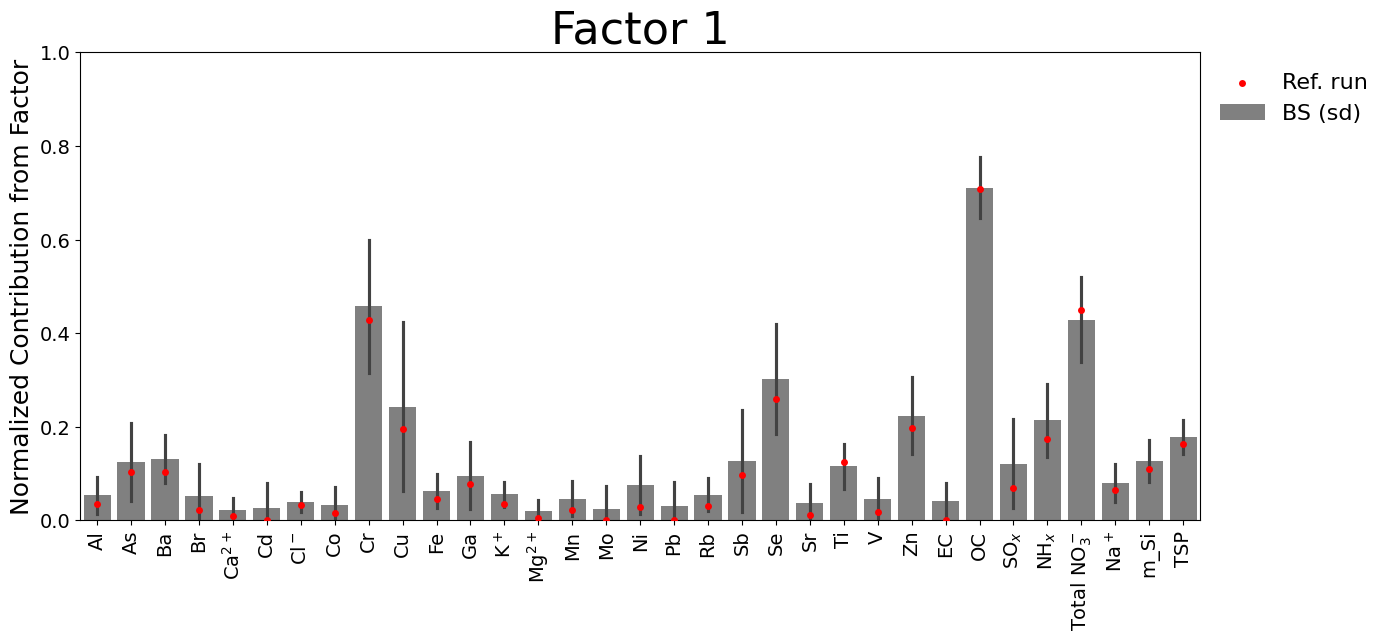

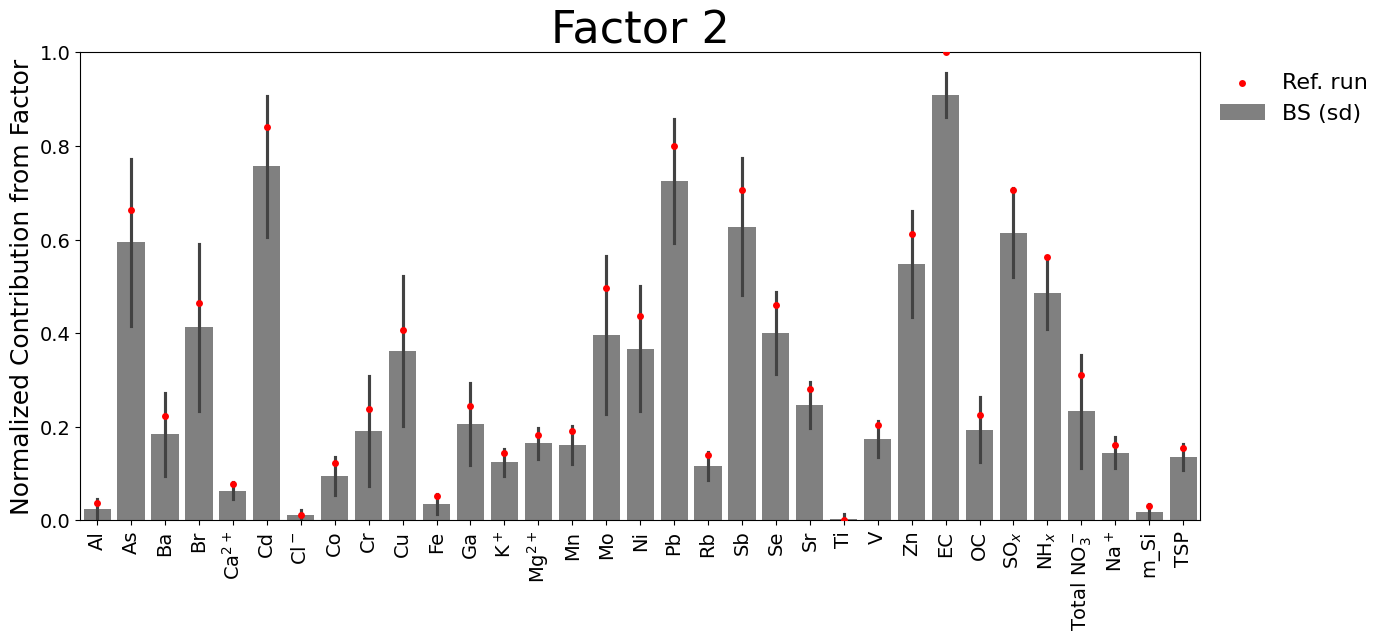

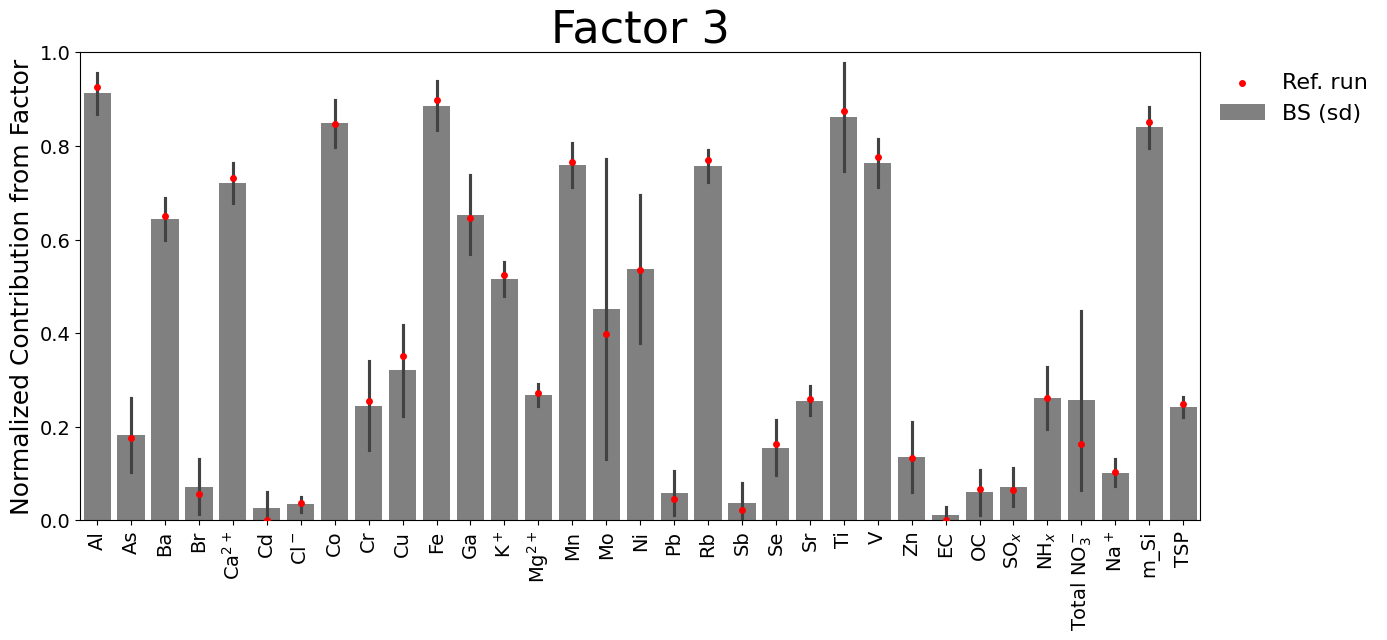

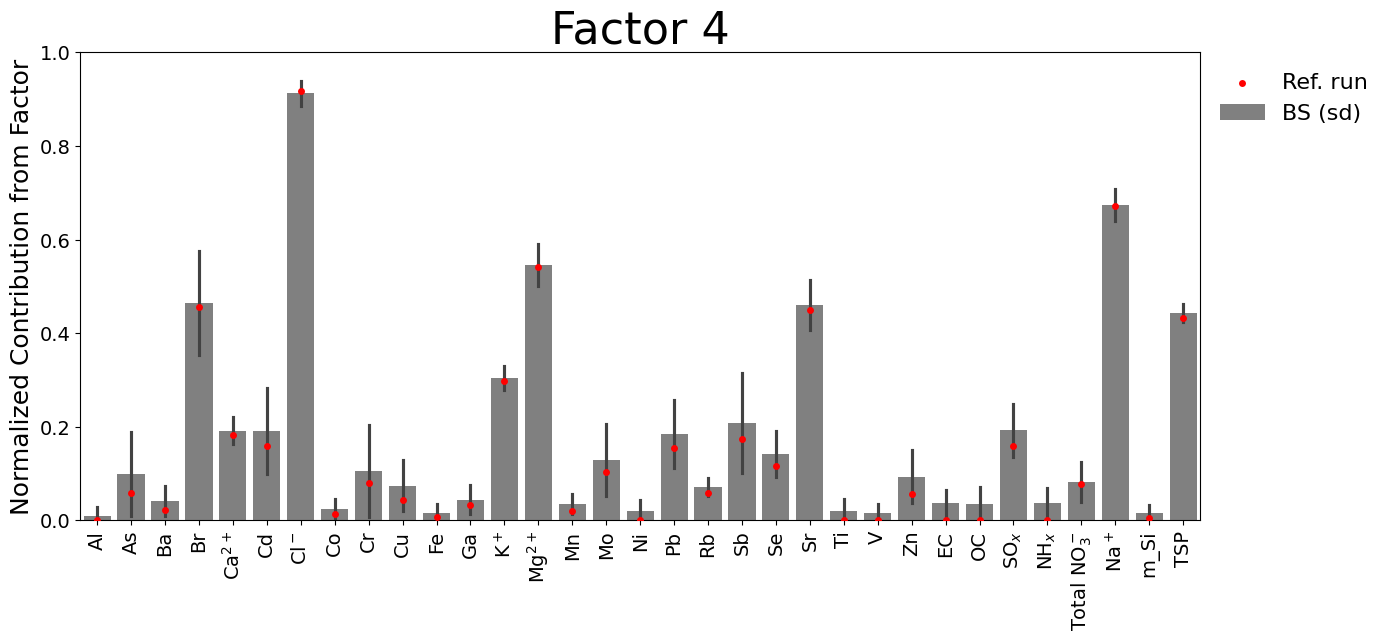

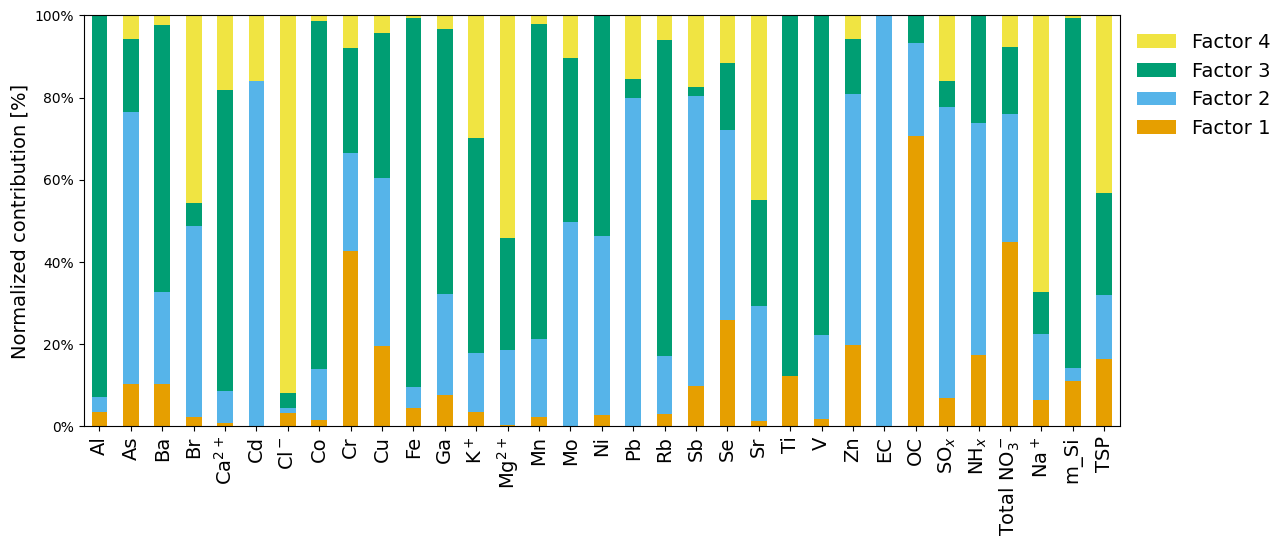

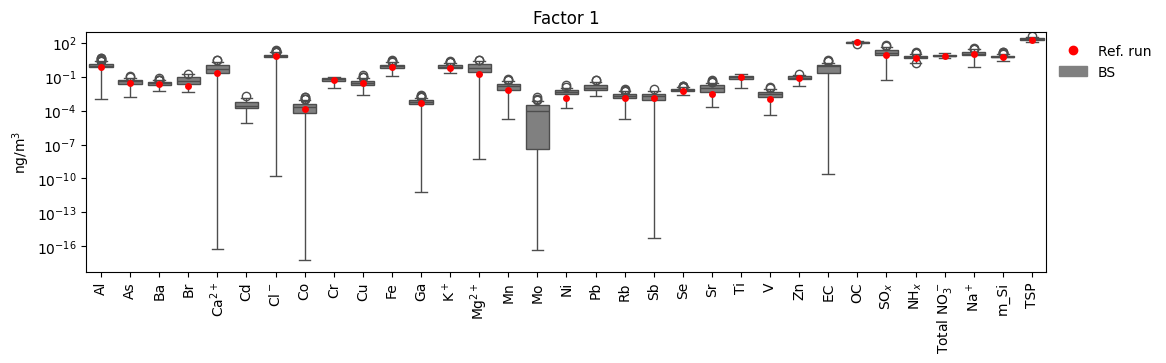

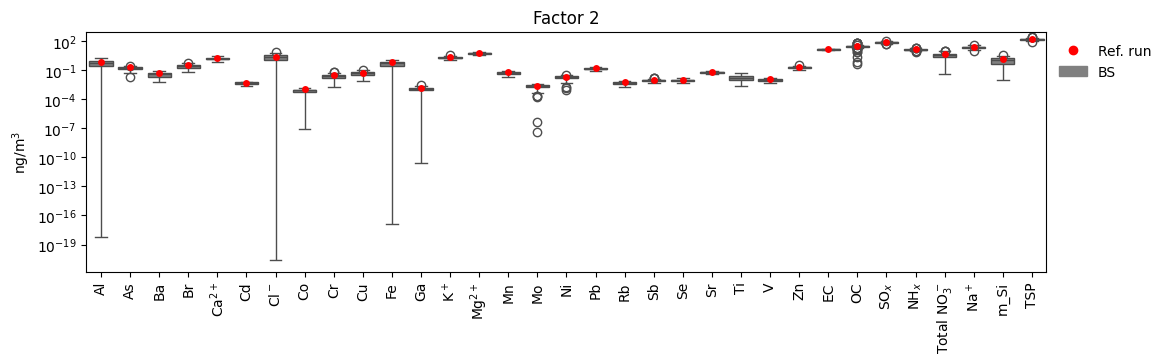

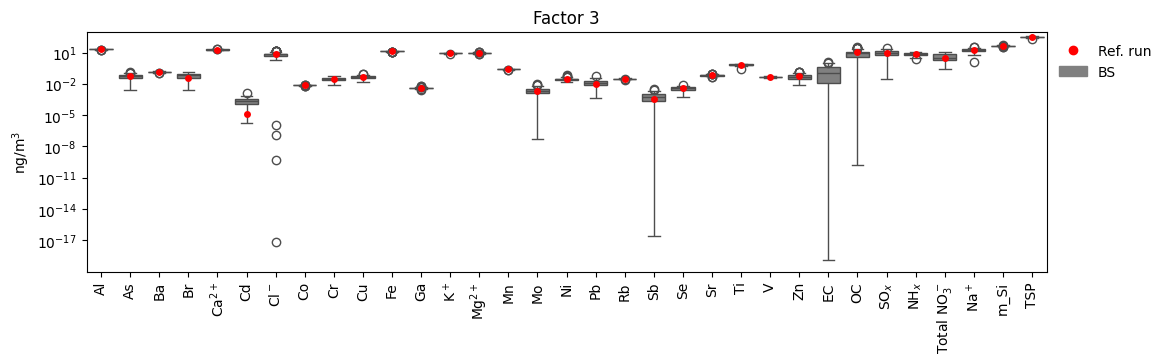

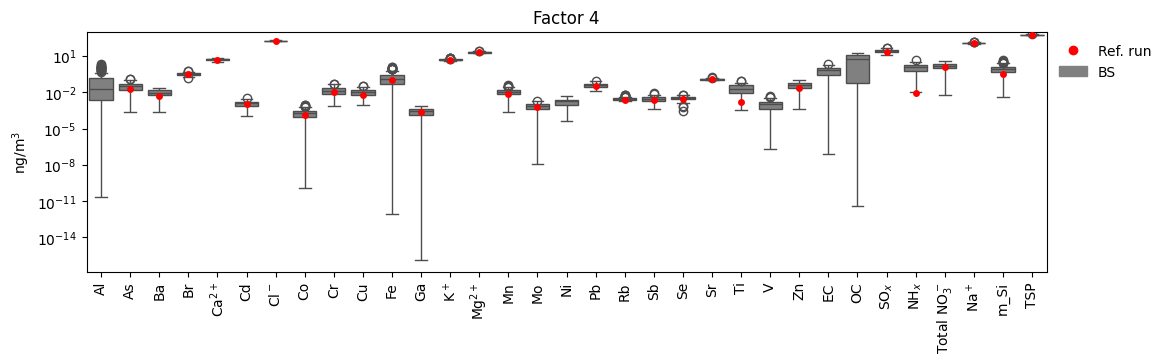

In [86]:
postNuukAll_4.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/4_factor_profile_post_all_')
postNuukAll_4.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/4_factor_contribution_post_all_')
postNuukAll_4.plot.plot_per_microgramm(constrained=False, plot_save=True, savedir='Figures_March/4_factor_postNuuk_2015_2023_')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtick

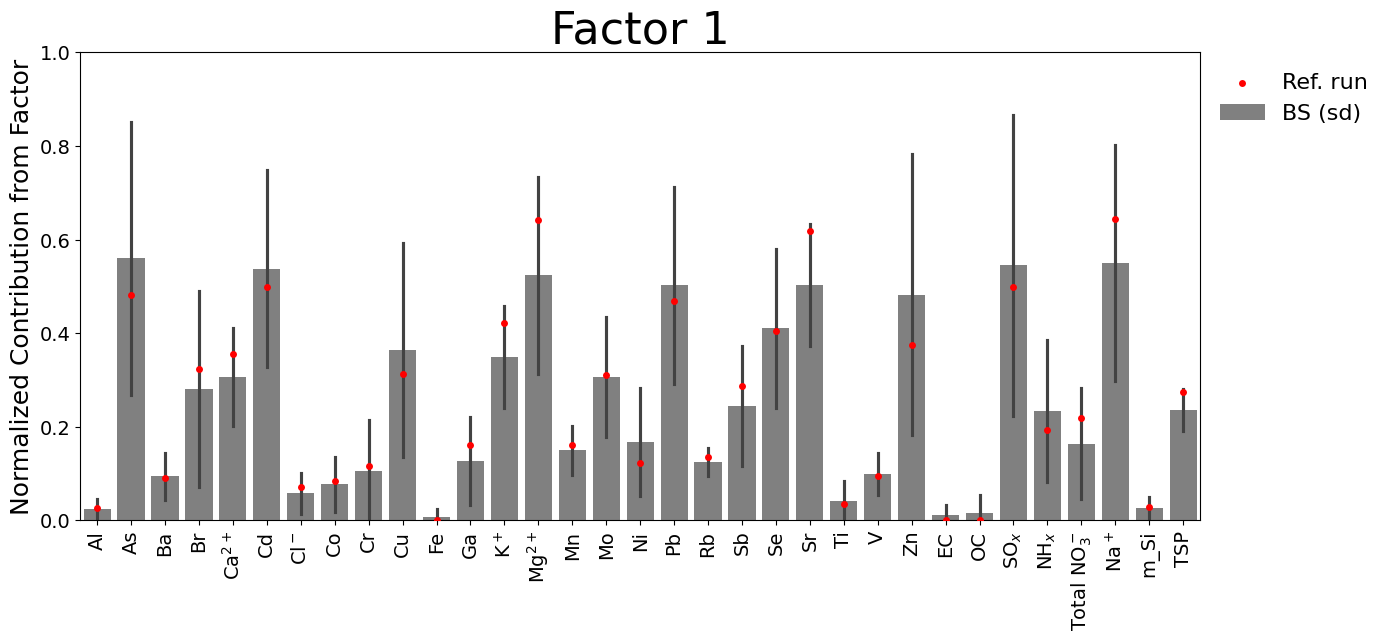

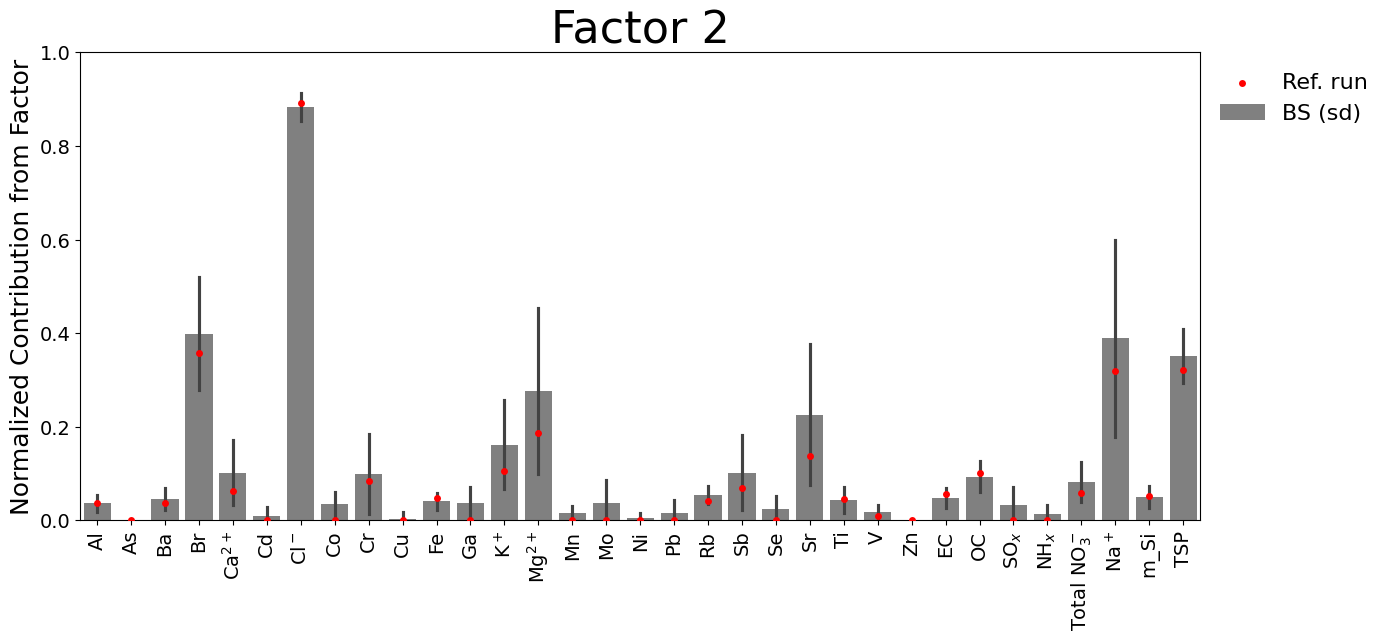

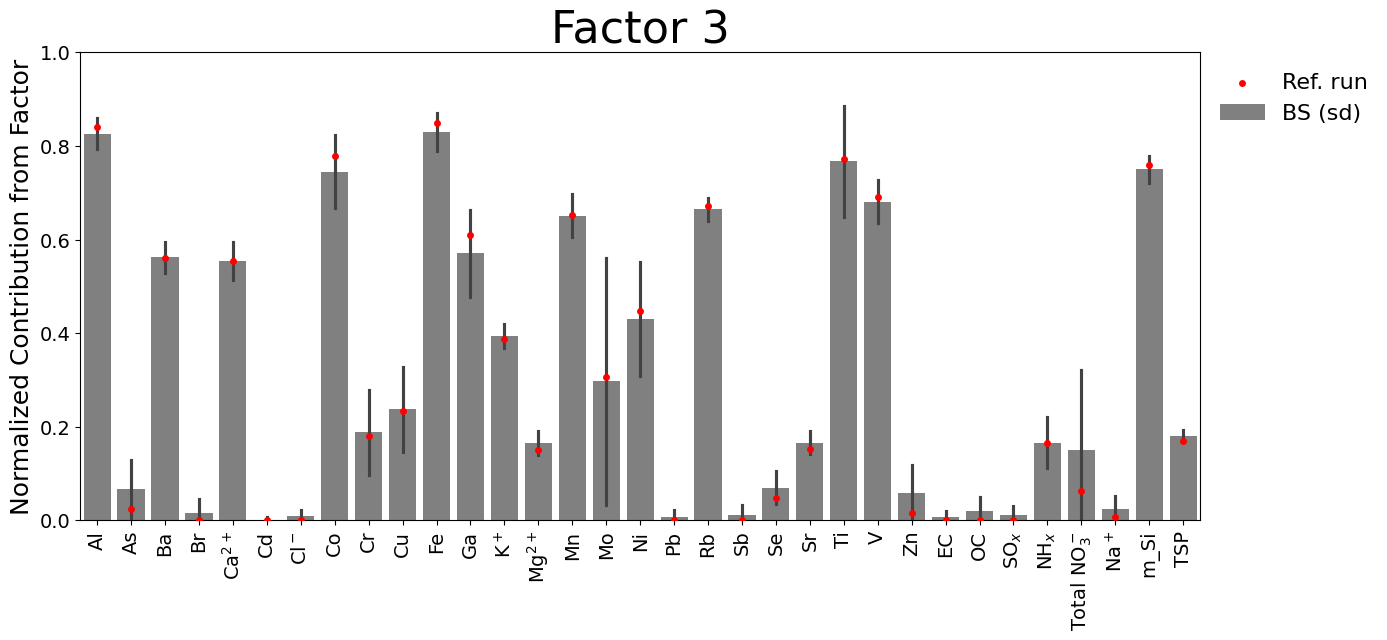

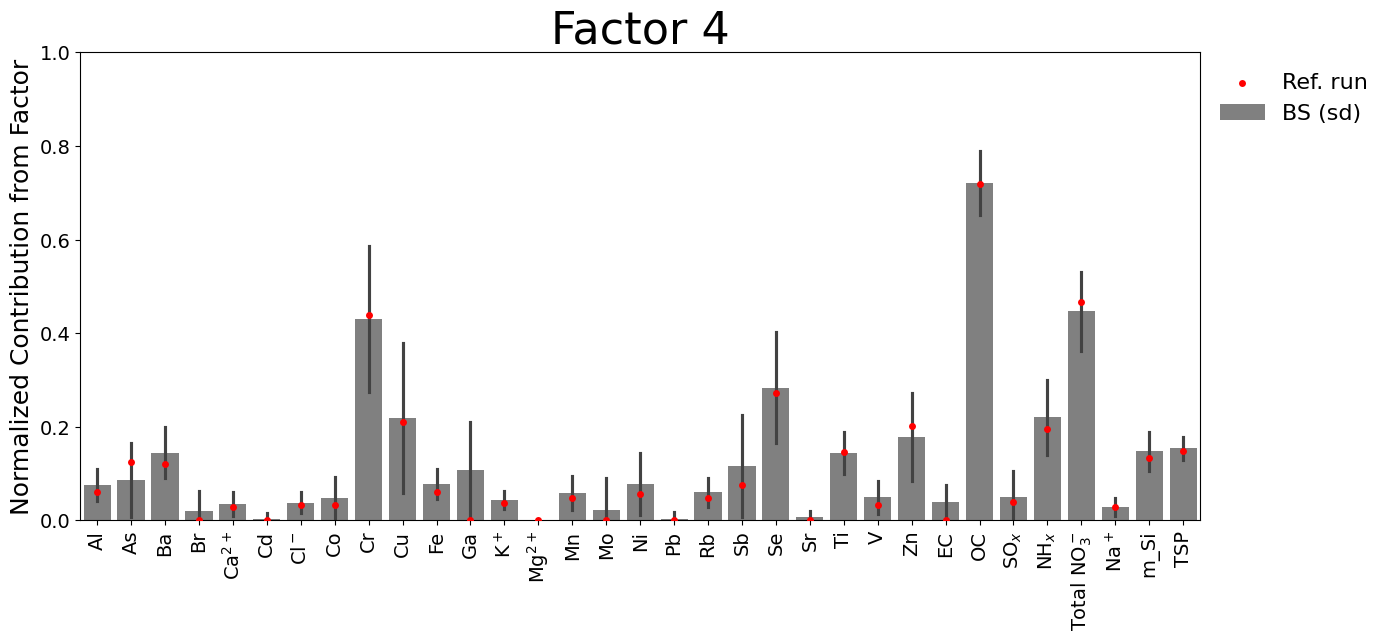

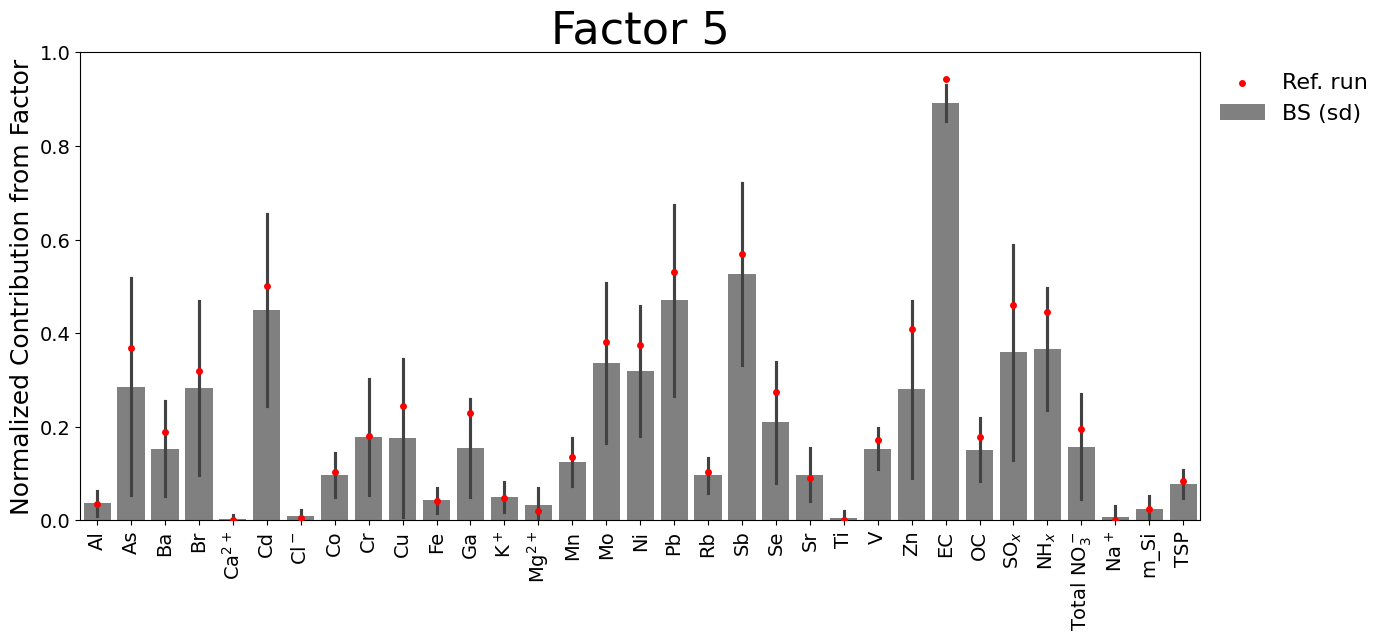

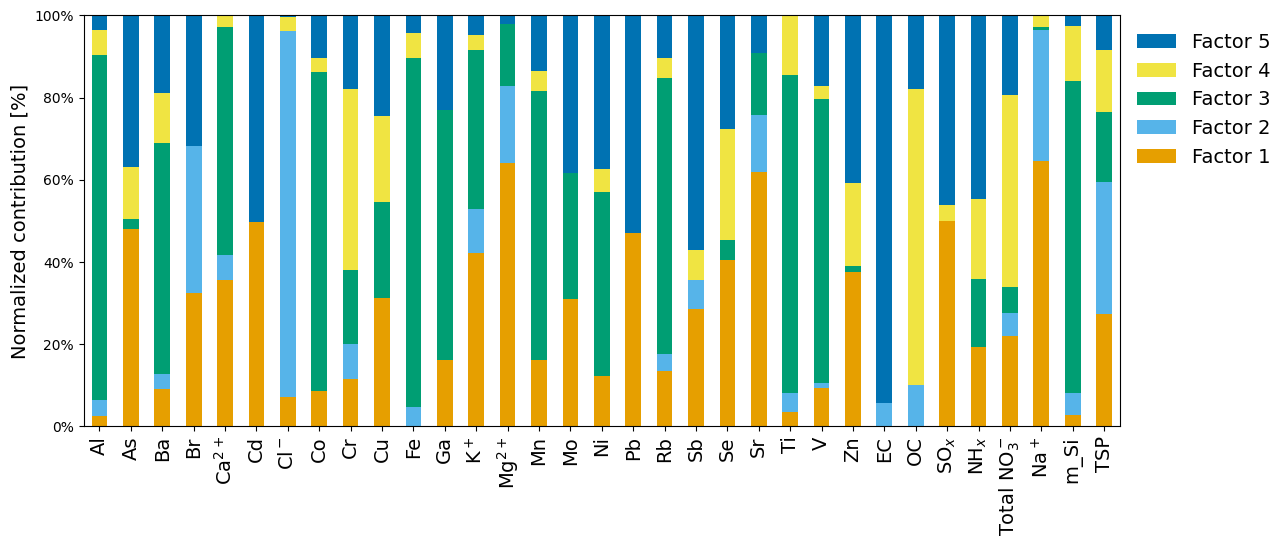

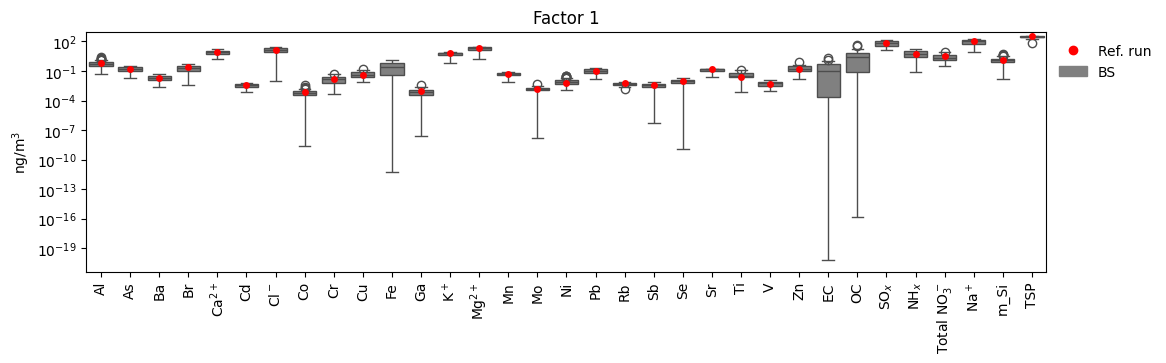

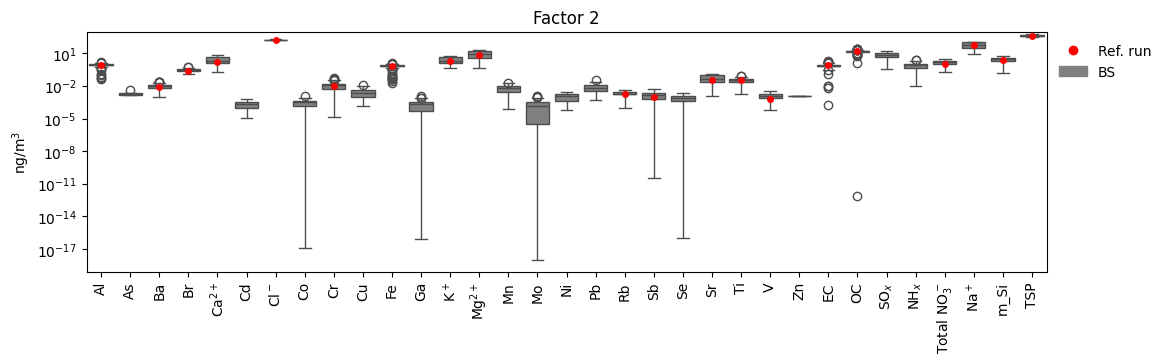

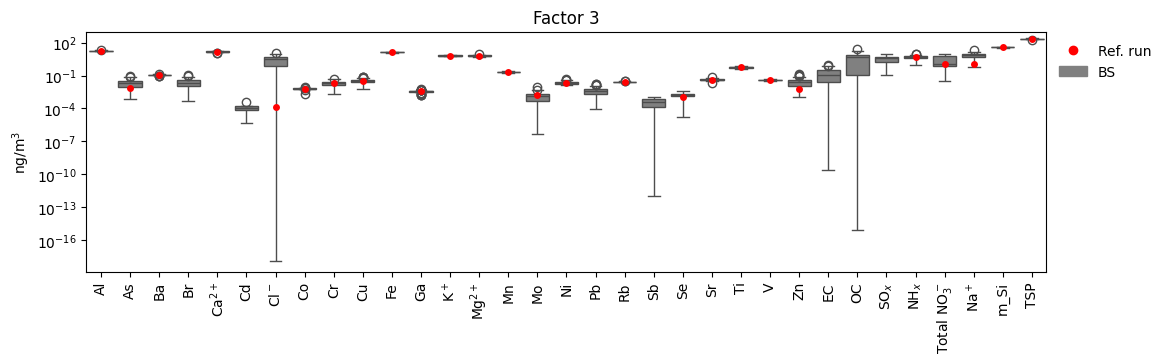

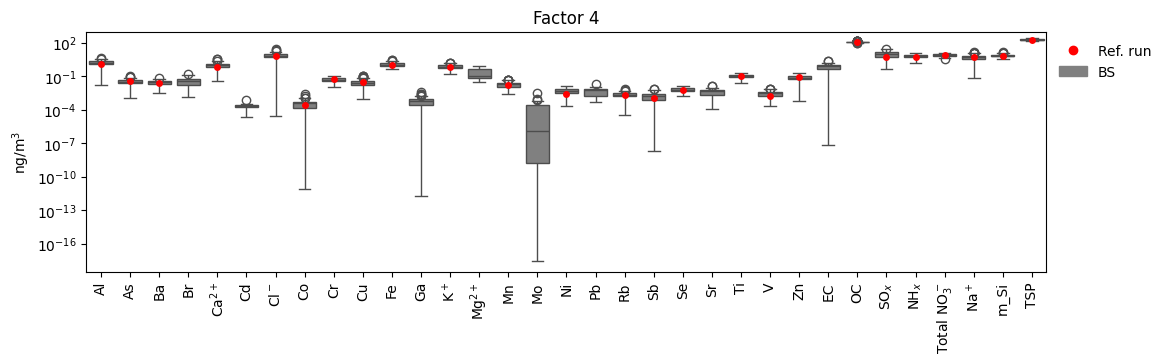

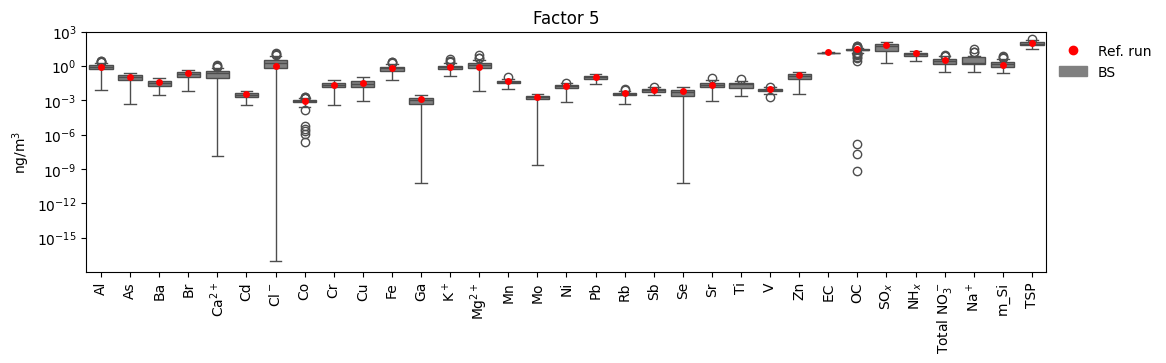

In [87]:
postNuukAll_5.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/5_factor_profile_post_all_')
postNuukAll_5.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/5_factor_contribution_post_all_')
postNuukAll_5.plot.plot_per_microgramm(constrained=False, plot_save=True, savedir='Figures_March/5_factor_postNuuk_2015_2023_')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyPMF/plotter.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtick

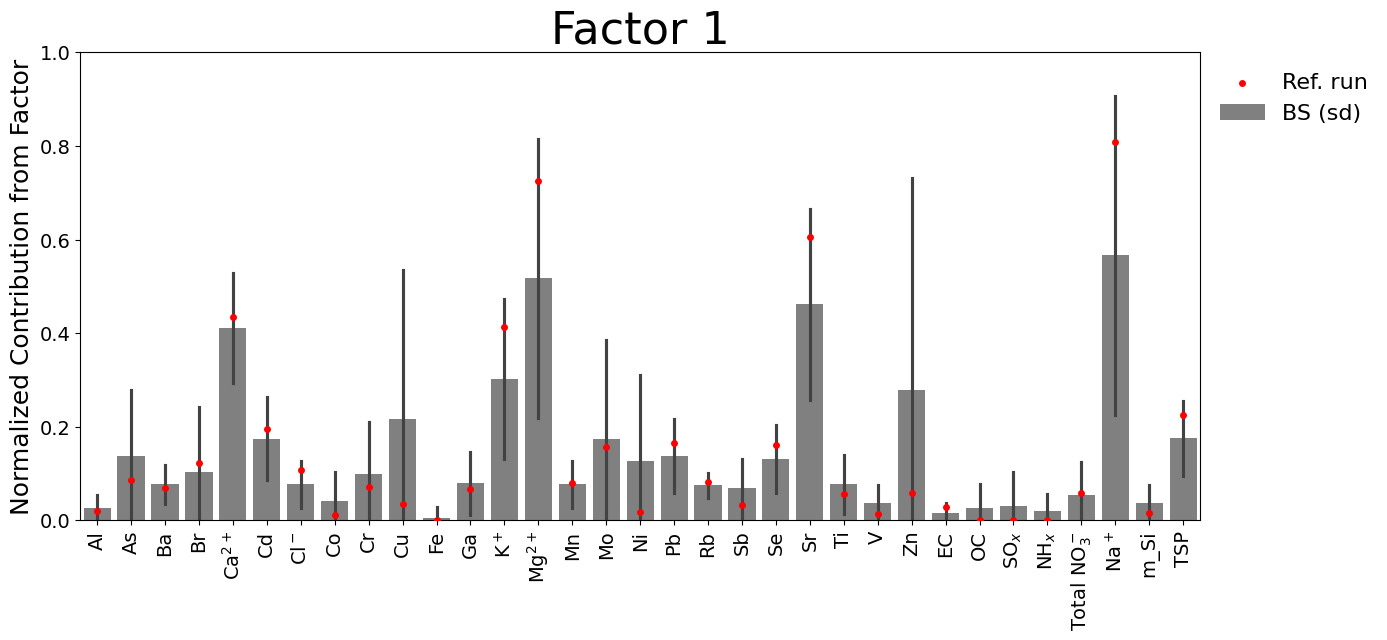

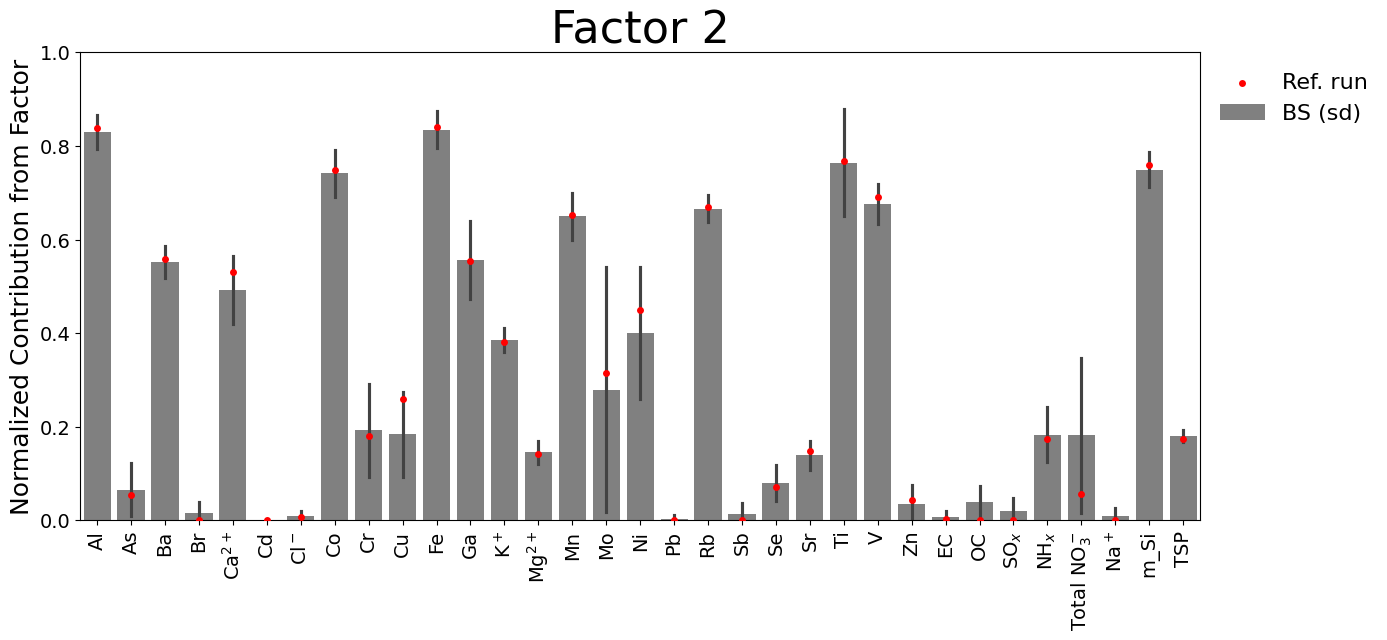

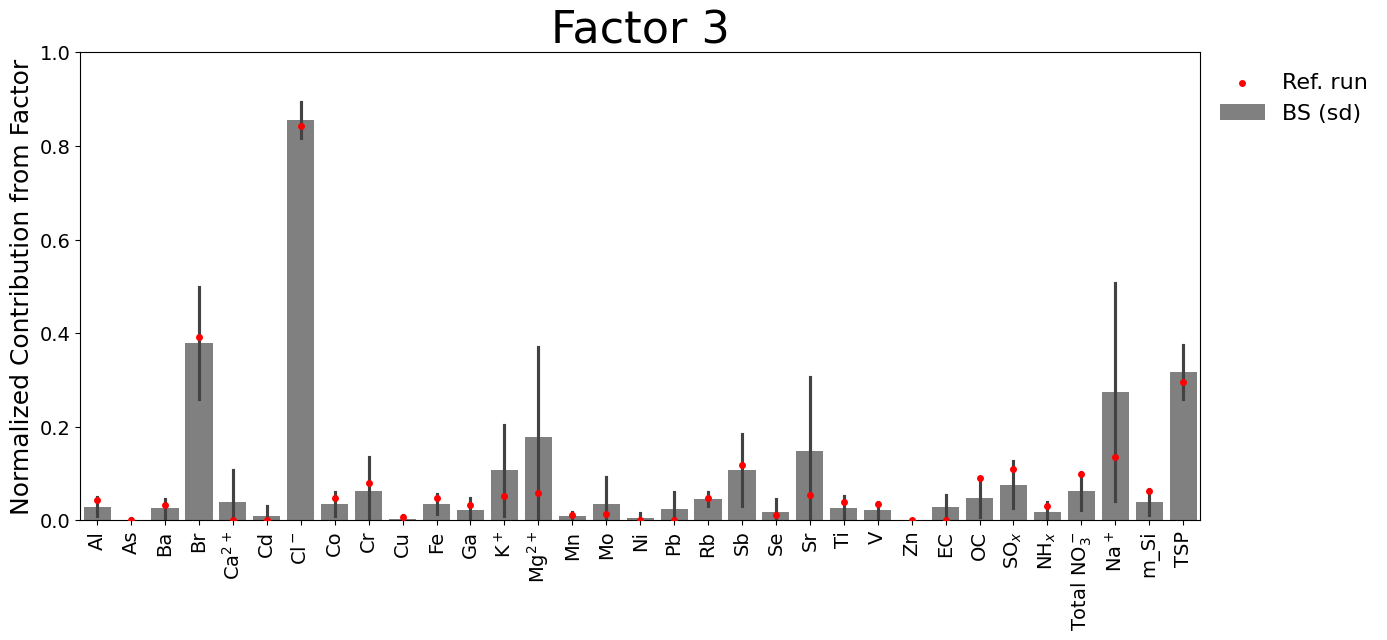

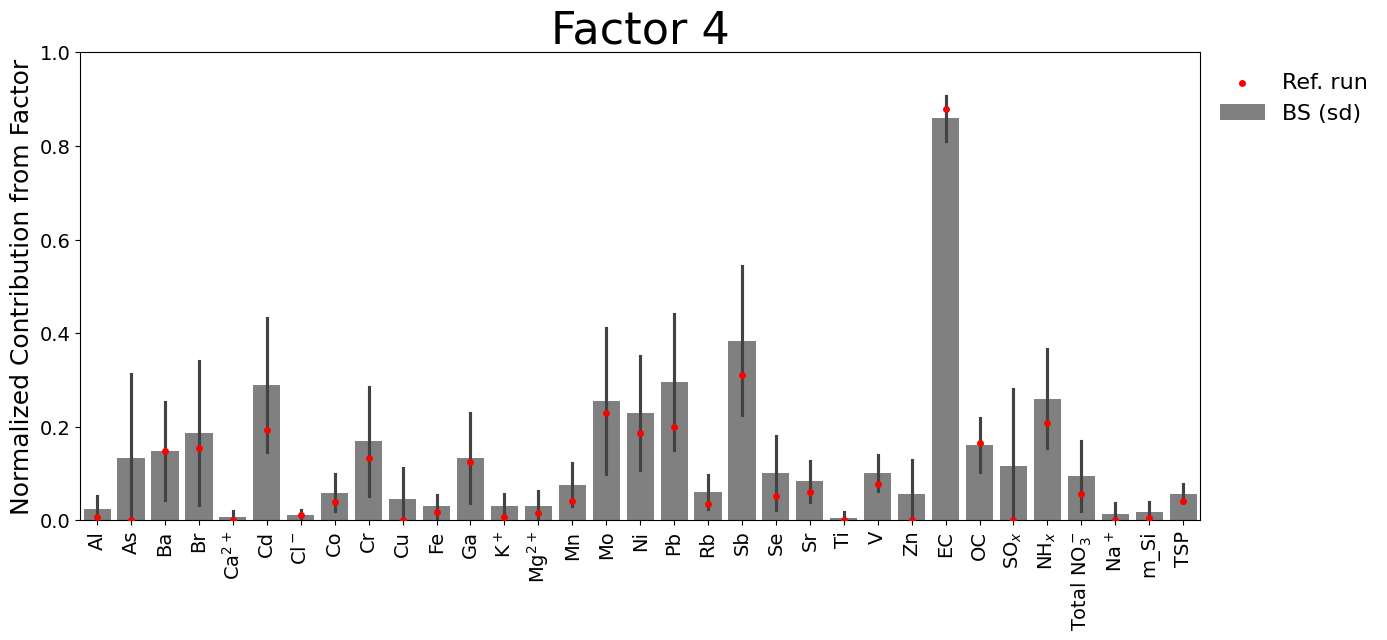

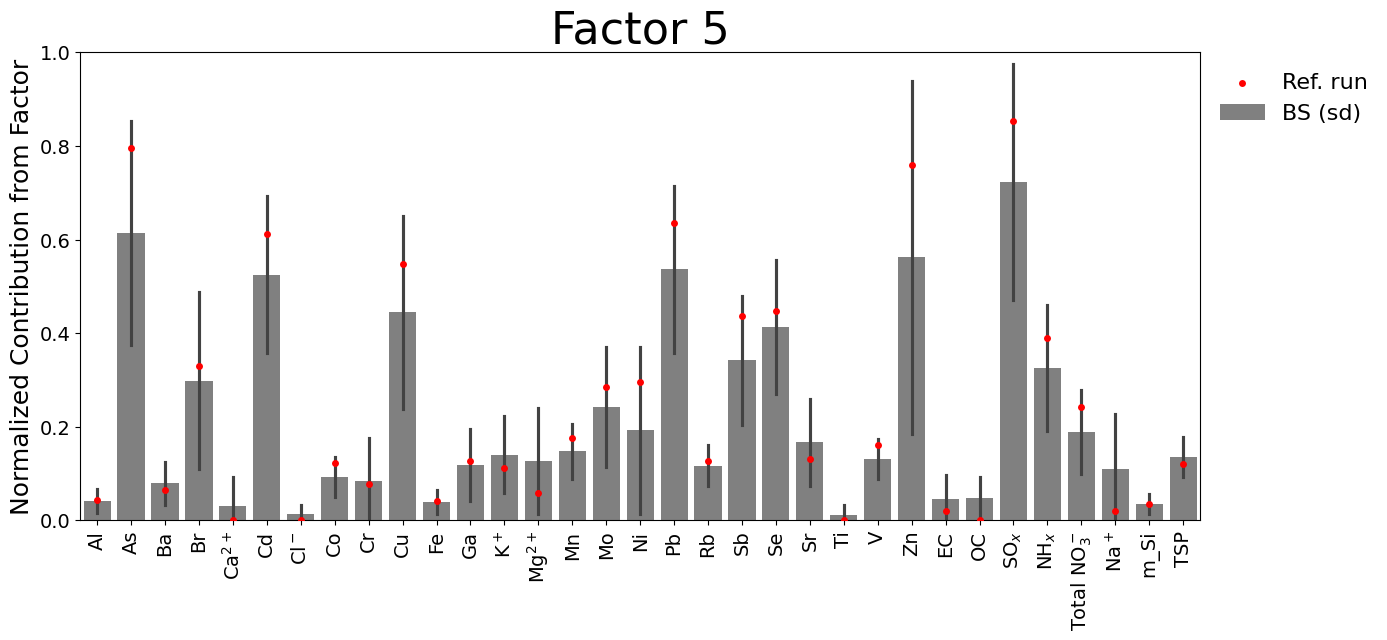

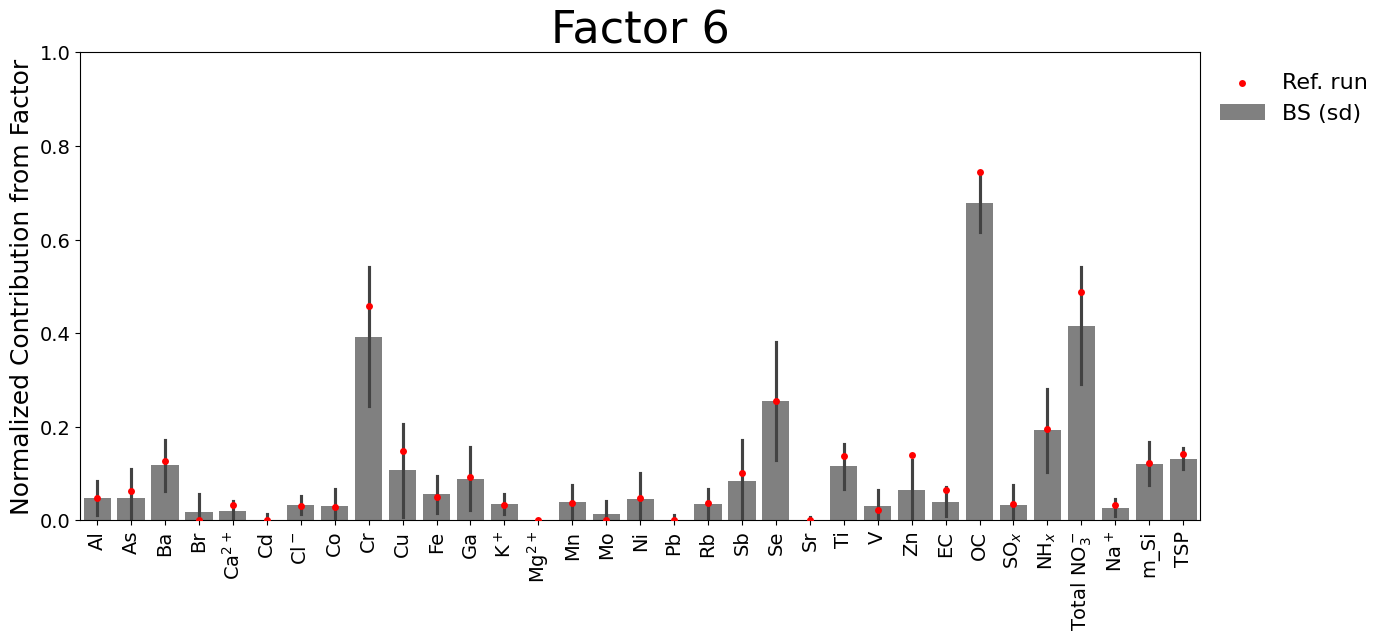

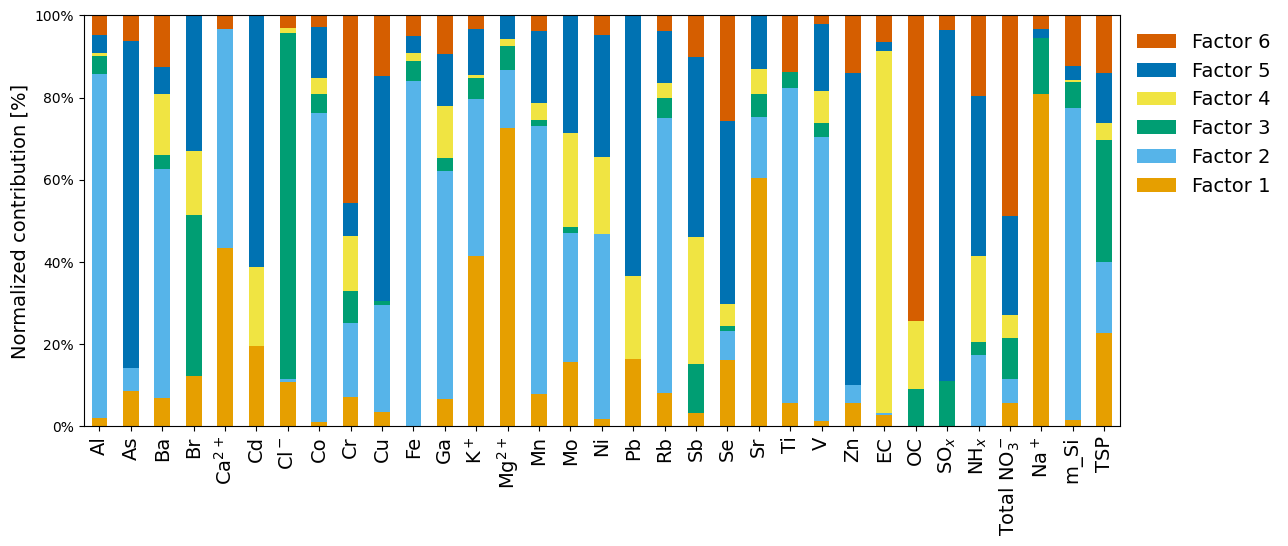

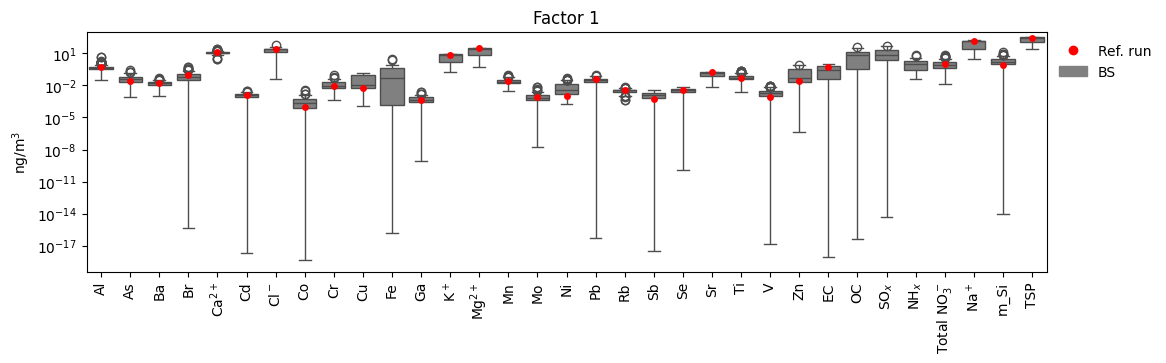

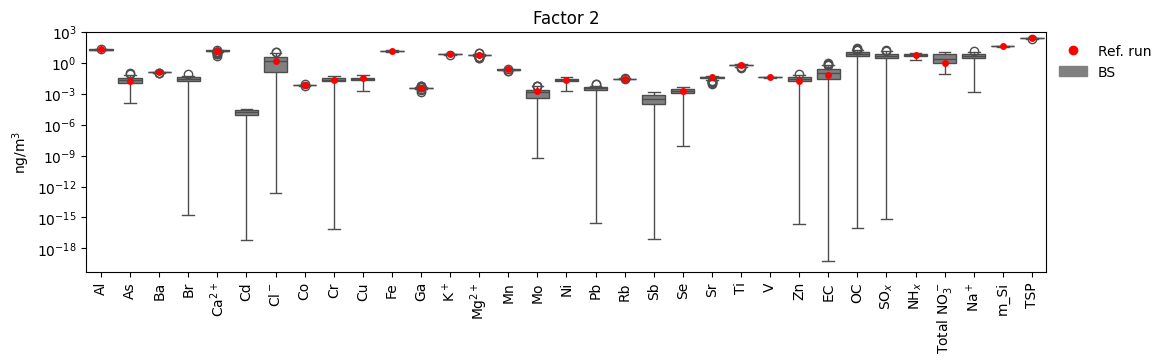

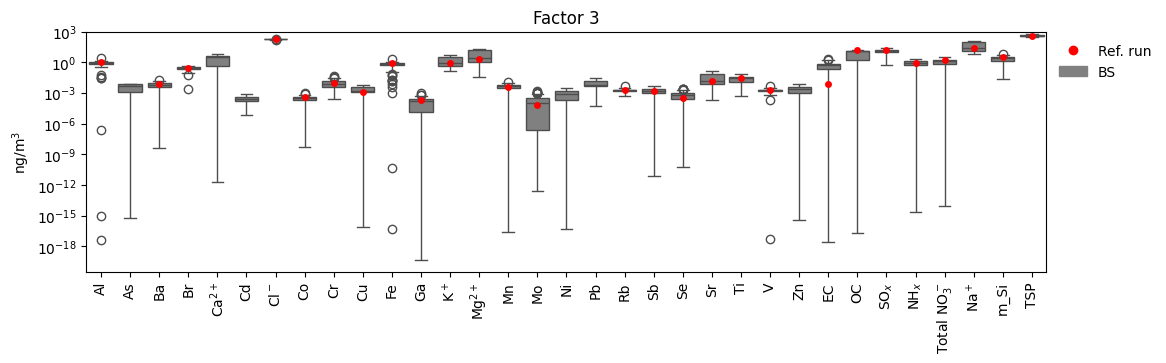

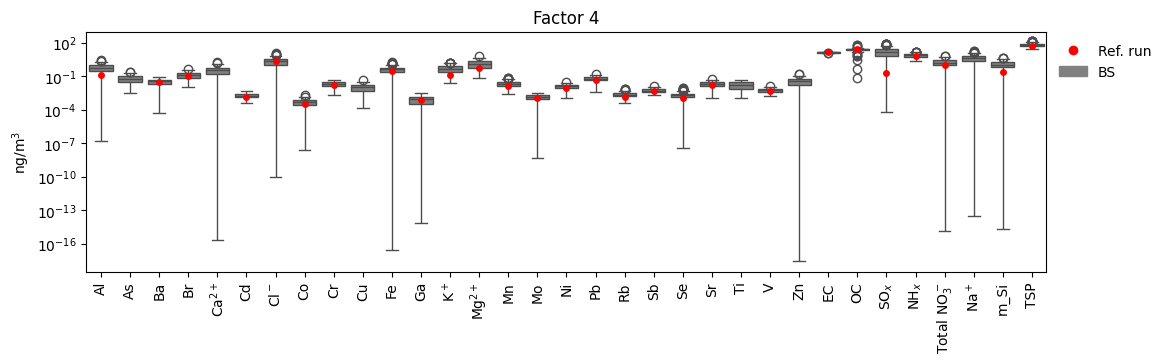

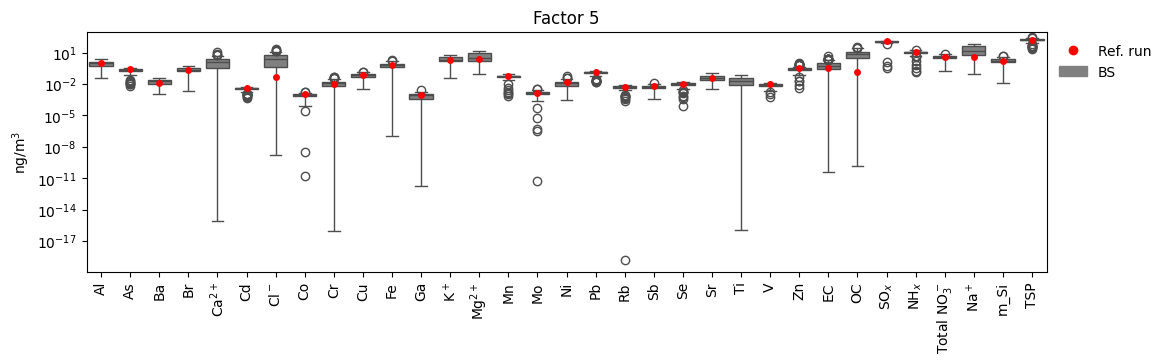

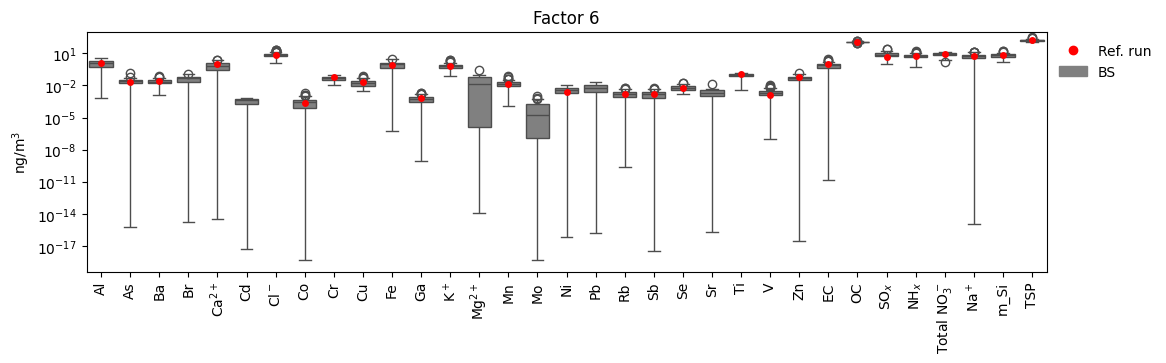

In [88]:
postNuukAll_6.plot.plot_totalspeciesum(constrained=False, plot_save=True, savedir='Figures_February/6_factor_profile_post_all_')
postNuukAll_6.plot.plot_stacked_profiles(constrained=False, plot_save=True, savedir='Figures_February/6_factor_contribution_post_all_')
postNuukAll_6.plot.plot_per_microgramm(constrained=False, plot_save=True, savedir='Figures_March/6_factor_postNuuk_2015_2023_')

In [ ]:
df = postNuukAll_4.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper left', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/4_factor_post_all_aerosol.pdf')
# Show the plot
plt.show()

In [ ]:
df = postNuukAll_4.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
df.reset_index(inplace=True)
#df.dropna(inplace=True)
columns_to_plot = df.columns
df.set_index('Date', inplace=True)

# Create figure
plt.figure(figsize=(10, 6))

# Get distinct colors from a colorblind-friendly colormap
colors = plt.get_cmap('tab10').colors  # Use 'tab10' for distinct, colorblind-friendly colors

# Group by year and plot each year separately with distinct colors
years = sorted(df.index.year.unique())
for i, (year, group) in enumerate(df.groupby(df.index.year)):
    plt.plot(group.index.dayofyear, group['Factor 1'], label=str(year), color=colors[i % len(colors)])

# Formatting
plt.xlabel('Day of Year')
plt.ylabel('Value')
plt.title('Yearly Time Series')
plt.legend(title="Year", loc='upper right')
plt.xticks([1, 91, 182, 274, 365], ['Jan', 'Apr', 'Jul', 'Oct', 'Dec'])  # Approximate month markers
plt.show()

In [ ]:
df_4 = postNuukAll_4.dfcontrib_b.copy()
for factor in df_4.columns:
    plot_yearly_variation_median(df_4, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/4_factor_postAll_median_yearly_contribution_{factor}.pdf')
    plt.show()

In [ ]:
df_4 = postNuukAll_4.dfcontrib_b.copy()
plot_mean_factor_variation(df_4)
plt.savefig('Figures_February/4_factor_postAll_mean_yearly_factor_variation.pdf')
plt.show()

In [ ]:
factor_scatter(df_4)
plt.savefig('Figures_March/4_factor_postNuuk_2015_2023_G_space.pdf')
plt.show()

In [ ]:
df = postNuukAll_5.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper left', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/5_factor_post_all_aerosol.pdf')
# Show the plot
plt.show()

In [ ]:
df_5 = postNuukAll_5.dfcontrib_b.copy()
plot_mean_factor_variation(df_5)
plt.savefig('Figures_February/5_factor_postAll_mean_yearly_factor_variation.pdf')
plt.show()

In [ ]:
df_5 = postNuukAll_5.dfcontrib_b.copy()
for factor in df_5.columns:
    plot_yearly_variation_mean(df_5, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/5_factor_postAll_median_yearly_contribution_{factor}.pdf')
    plt.show()

In [ ]:
factor_scatter(df_5)
plt.savefig('Figures_March/5_factor_postNuuk_2015_2023_G_space.pdf')
plt.show()

In [ ]:
df = postNuukAll_6.dfcontrib_b.copy()
#df.dropna(inplace=True)
columns_to_plot = df.columns
n_factors = len(df.columns)
# Prepare the plot
fig, ax = plt.subplots(figsize=(36, 12))

# Create the stacked area plot dynamically
cumulative = pd.Series(0, index=df.index)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

for col, color in zip(columns_to_plot, colors[:n_factors]):
    ax.fill_between(
        df.index,
        cumulative + df[col],  # Upper boundary of the area
        cumulative,            # Lower boundary of the area
        color=color,
        alpha=0.5,
        label=col
    )
    cumulative += df[col]  # Update cumulative sum for the next layer

# Set major ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
ax.xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))

ax.tick_params(axis='both', labelsize=14)
# Set x-axis limits to start with the first date and end with the last date
ax.set_xlim(df.index.min(), df.index.max())

# Add gridlines, labels, title, and legend
ax.grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax.set_title('Stacked Contribution', fontsize=24)
ax.set_ylabel('Total Aerosol mass [ng/m$^3$]', fontsize=18)
ax.legend(loc='upper left', fontsize=20)
# Rotate labels for readability
plt.xticks(rotation=45)

plt.savefig('Figures_February/6_factor_post_all_aerosol.pdf')
# Show the plot
plt.show()

In [ ]:
df_6 = postNuukAll_6.dfcontrib_b.copy()
for factor in df_6.columns:
    plot_yearly_variation_median(df_6, factor)
    plt.tight_layout()
    plt.savefig(f'Figures_February/6_factor_postAll_median_yearly_contribution_{factor}.pdf')
    plt.show()

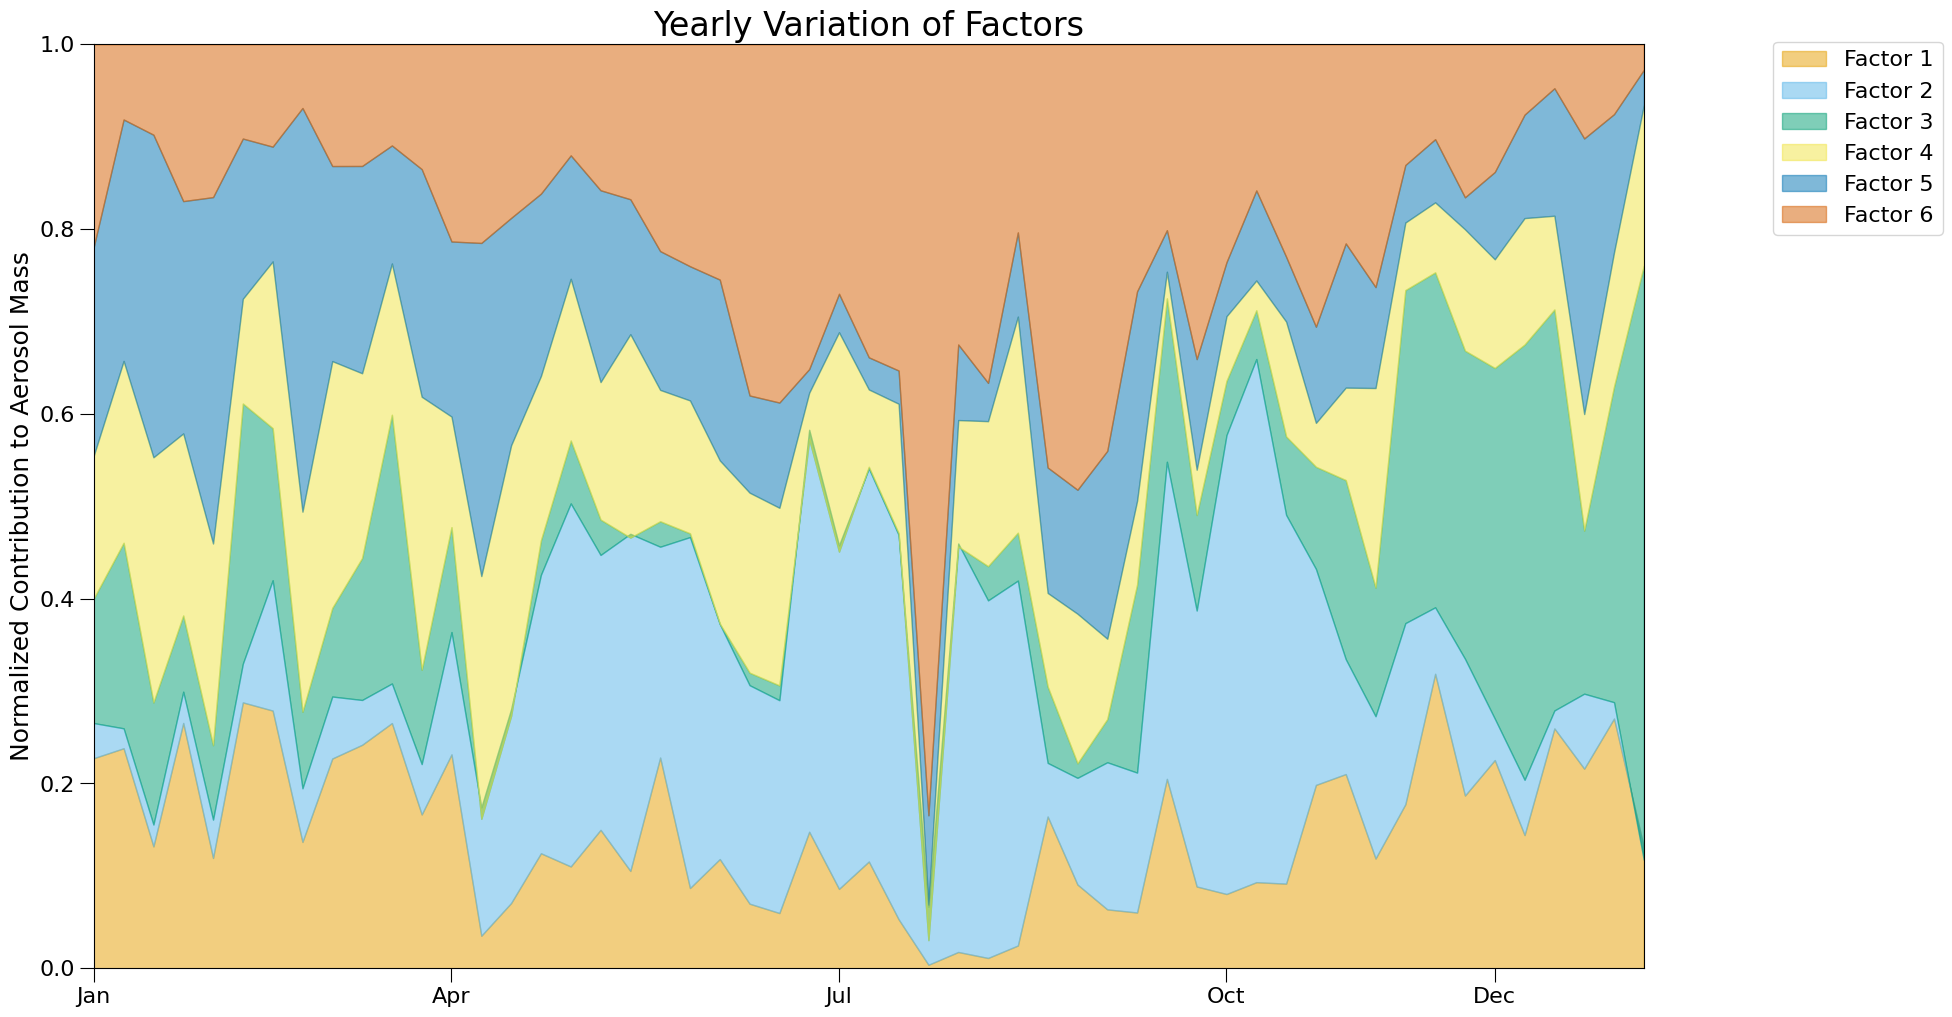

In [90]:
df_6 = postNuukAll_6.dfcontrib_b.copy()
plot_mean_factor_variation(df_6)
plt.savefig('Figures_February/6_factor_postAll_mean_yearly_factor_variation.pdf')
plt.show()

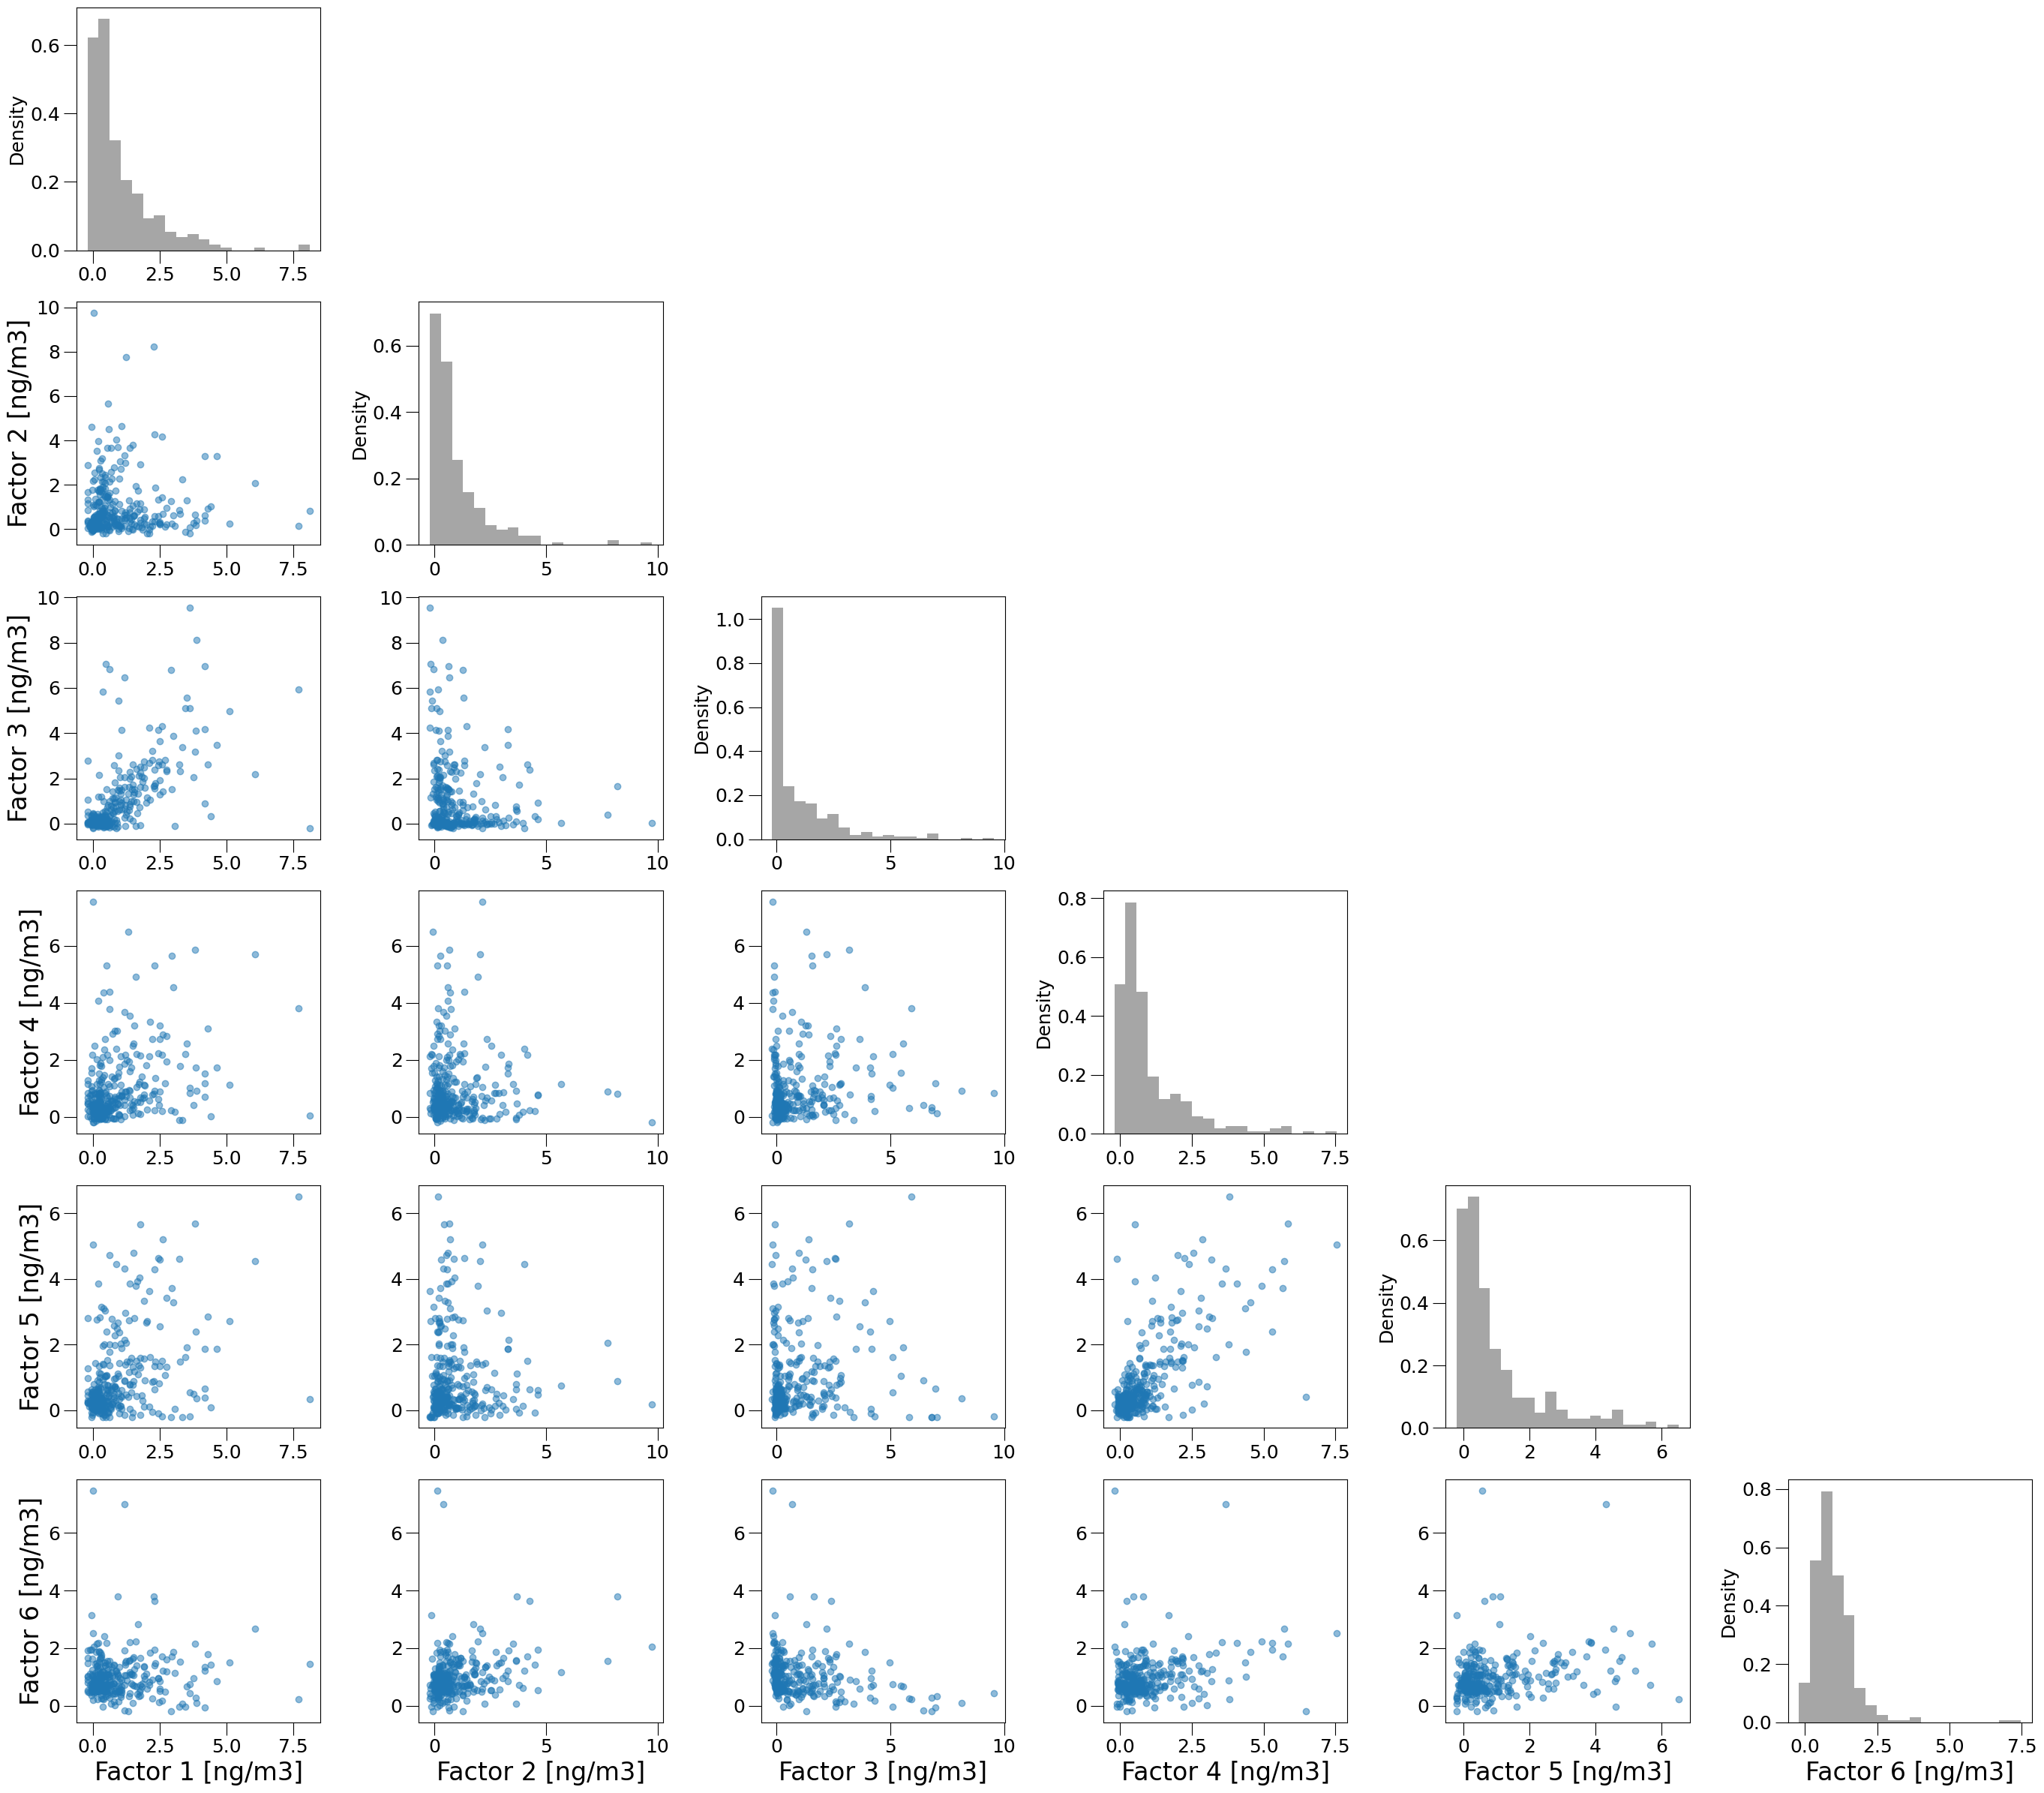

In [91]:
factor_scatter(df_6)
plt.savefig('Figures_March/6_factor_postNuuk_2015_2023_G_space.pdf')
plt.show()